# Time Evolution

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.convolution import Tophat2DKernel
from regions import CircleSkyRegion, RectangleSkyRegion

from gammapy.detect import compute_lima_on_off_image,compute_lima_image # quelle différence entre les deux ?
from gammapy.data import DataStore
from gammapy.irf import make_mean_psf
from gammapy.maps import Map, MapAxis, WcsGeom
from gammapy.cube import (
    MapDatasetMaker,
    PSFKernel,
    MapDataset,
    RingBackgroundMaker,
    SafeMaskMaker,
    #RingBackgroundEstimator,
)
from gammapy.modeling.models import (
    SkyModel,
    SkyModels,
    BackgroundModel,
    PowerLawSpectralModel,
    PowerLaw2SpectralModel,
    PointSpatialModel,
    ExpCutoffPowerLawSpectralModel,
    SkyDiffuseCube,
    TemplateSpatialModel,
    GaussianSpatialModel
)
from gammapy.stats import significance, excess # utiles ?

from gammapy.modeling import Fit
from astropy.time import Time

src_pos = SkyCoord(359.94, -0.04, unit="deg", frame="galactic")

import gammapy
gammapy.__version__

'0.15'

In [30]:
emin, emax = [0.5, 100] * u.TeV

energy_axis = MapAxis.from_bounds(
    emin.value, emax.value, 20, unit="TeV", name="energy", interp="log"
)
geom = WcsGeom.create(
    skydir=(0, 0),
    binsz=0.02,
    width=(10, 8),
    coordsys="GAL",
    proj="CAR",
    axes=[energy_axis],
)

geom2d = WcsGeom.create(
    skydir=(0, 0),
    binsz=0.02,
    width=(10, 8),
    coordsys="GAL",
    proj="CAR",
)

energy_axis_true = MapAxis.from_bounds(
    0.3, 200, 30, unit="TeV", name="energy", interp="log"
)

In [31]:
from pathlib import Path

# Directory for outputs

path = Path("../../../../gammapy_data/GC_variability2020/hap-hd")
path.mkdir(exist_ok=True)

pathm = Path(path/"mapdatasets")
pathm.mkdir(exist_ok=True)

pathp = Path(path/"parameter_stability")
pathp.mkdir(exist_ok=True)

pathpar = Path(pathp/"2amps_0indexes_1cutoff")
pathpar.mkdir(exist_ok=True)

# To find the model template
pathmo = Path(path/"models")
pathmo.mkdir(exist_ok=True)

model_name = pathmo/"models_template_2cutoff.yaml"

## Creating the datasets

In [ ]:
mapdataset_dict = {}

for k in range (2004,2020):
    name = "map" + str(k)
    mapdataset_dict[k] = MapDataset.create(
    geom=geom, energy_axis_true=energy_axis_true, name=name)

for year in range(2004,2020):
    
    filename = "mapdataset" +str(year)+".fits.gz"
    mapdataset_dict[year] = MapDataset.read(pathm/filename)

## Reading the model template

In [ ]:
modelGC,modelG09, model_diff = SkyModels.read(model_name)

## Setting which parameters will vary

In [ ]:
modelGC.parameters["index"].frozen = True
modelGC.parameters["index"].value = 1.8
modelGC.parameters["lon_0"].frozen = True
modelGC.parameters["lat_0"].frozen = True
modelGC.parameters["amplitude"].frozen = False
modelGC.parameters["reference"].frozen = True 

modelG09.parameters["index"].frozen = True
modelG09.parameters["lon_0"].frozen = True
modelG09.parameters["lat_0"].frozen = True
modelG09.parameters["amplitude"].frozen = False

model_diff.parameters["index"].frozen = True
model_diff.parameters["index"].value = 2.3
model_diff.parameters["norm"].frozen = True
model_diff.parameters["amplitude"].frozen = False
model_diff.parameters["reference"].frozen = True

In [ ]:
# if there are cutoffs in the spectra

modelGC.parameters["lambda_"].frozen = False
model_diff.parameters["lambda_"].frozen = True
model_diff.parameters["lambda_"].value = 0.0

## Constructing the mask

In [8]:
fit_region = RectangleSkyRegion(src_pos, 4*u.deg, 2*u.deg)

J1745_303_region = CircleSkyRegion(SkyCoord(358.6,  -0.6, unit="deg", frame="galactic"), 0.5 * u.deg)

fit_mask = geom.region_mask([fit_region])*geom.region_mask([J1745_303_region] , inside=False)

fit_mask = Map.from_geom(geom, data=fit_mask)

## Applying the mask and the model template

In [9]:
for year in range(2004,2020):
    mapdataset_dict[year].fit_mask = fit_mask
    mapdataset_dict[year].models =  modelGC.copy() + modelG09.copy() +  model_diff.copy()
    mapdataset_dict[year].background_model.parameters['norm'].value = 1.0

# Fitting the datasets

In [10]:
def fit_dataset(mapdataset):
    fit = Fit([mapdataset])
    result = fit.run()
    
    table = result.parameters.to_table()

    rescov = fit.covariance()
    #ampSGRA = mapdataset.models.parameters[3]
    #ampdiff = mapdataset.models.parameters[12]
    #normbkg = mapdataset.background_model.parameters['norm']
    
    #cov= rescov.parameters.get_subcovariance([ampSGRA, ampdiff, normbkg])
    
    return table, rescov, result

In [11]:
%%time

results_per_year = dict()
results = []
cov_per_year = dict()


for year in range(2004,2020):
    
    table, cov, result = fit_dataset(mapdataset_dict[year])
    
    results.append(result)
    
    results_per_year[year] = table
    
    cov_per_year[year] = cov
    

/home/samuel/anaconda3/envs/gammapy-0.15/lib/python3.7/site-packages/gammapy/cube/fit.py:1480: RuntimeWarning: invalid value encountered in less
  tmp.data[tmp.data < 0.0] = 0


CPU times: user 37min 17s, sys: 4min 12s, total: 41min 29s
Wall time: 41min 30s


In [12]:
years = []
for year in range(2004,2020):
    if results[year-2004].message =='Optimization terminated successfully.':
        years.append(year)

In [28]:
results

[OptimizeResult
 
 	backend    : minuit
 	method     : minuit
 	success    : True
 	message    : Optimization terminated successfully.
 	nfev       : 270
 	total stat : 493366.33, OptimizeResult
 
 	backend    : minuit
 	method     : minuit
 	success    : True
 	message    : Optimization terminated successfully.
 	nfev       : 281
 	total stat : 570621.06, OptimizeResult
 
 	backend    : minuit
 	method     : minuit
 	success    : True
 	message    : Optimization terminated successfully.
 	nfev       : 264
 	total stat : 340196.46, OptimizeResult
 
 	backend    : minuit
 	method     : minuit
 	success    : True
 	message    : Optimization terminated successfully.
 	nfev       : 291
 	total stat : 136186.22, OptimizeResult
 
 	backend    : minuit
 	method     : minuit
 	success    : False
 	message    : Optimization failed. Estimated distance to minimum too large.
 	nfev       : 201
 	total stat : 206597.77, OptimizeResult
 
 	backend    : minuit
 	method     : minuit
 	success    : Tru

In [14]:
table

name,value,error,unit,min,max,frozen
str9,float64,float64,str14,float64,float64,bool
lon_0,3.599e+02,0.000e+00,deg,nan,nan,True
lat_0,-4.000e-02,0.000e+00,deg,-9.000e+01,9.000e+01,True
index,1.714e+00,1.011e-01,,nan,nan,False
amplitude,1.940e-12,1.129e-13,cm-2 s-1 TeV-1,nan,nan,False
reference,1.000e+00,0.000e+00,TeV,nan,nan,True
lambda_,1.598e-01,3.000e-02,TeV-1,nan,nan,False
alpha,1.000e+00,0.000e+00,,nan,nan,True
lon_0,8.791e-01,0.000e+00,deg,nan,nan,True
lat_0,8.930e-02,0.000e+00,deg,-9.000e+01,9.000e+01,True


# Extracting parameters (only one cell to run)

In [19]:
# Spectral models without cutoffs (indexes fixed)

ampsGC = []
ampsGC_err = []
ampsdiff = []
ampsdiff_err = []
norms = []
norms_err = []


for year in years:

    ampsGC.append(results_per_year[year]['value'][3])
    ampsGC_err.append(results_per_year[year]['error'][3])
    ampsdiff.append(results_per_year[year]['value'][12])
    ampsdiff_err.append(results_per_year[year]['error'][12])
   
    norms.append(results_per_year[year]['value'][14])
    norms_err.append(results_per_year[year]['error'][14])

In [131]:
# Spectral models without cutoffs (indexes unfrozen)

indexGC = []
indexGC_err = []
ampsGC = []
ampsGC_err = []


indexdiff = []
indexdiff_err = []
ampsdiff = []
ampsdiff_err = []
norms = []
norms_err = []


for year in years:
    indexGC.append(results_per_year[year]['value'][2])
    indexGC_err.append(results_per_year[year]['error'][2])
    ampsGC.append(results_per_year[year]['value'][3])
    ampsGC_err.append(results_per_year[year]['error'][3])
    
    indexdiff.append(results_per_year[year]['value'][11])
    indexdiff_err.append(results_per_year[year]['error'][11])
    ampsdiff.append(results_per_year[year]['value'][12])
    ampsdiff_err.append(results_per_year[year]['error'][12])
   
    norms.append(results_per_year[year]['value'][14])
    norms_err.append(results_per_year[year]['error'][14])

In [46]:
# Spectral models with a cutoff for the central source (both indexes unfrozen)

indexGC = []
indexGC_err = []
ampsGC = []
ampsGC_err = []
lambdaGC = []
lambdaGC_err = []

indexdiff = []
indexdiff_err = []
ampsdiff = []
ampsdiff_err = []

norms = []
norms_err = []


for year in years:

    indexGC.append(results_per_year[year]['value'][2])
    indexGC_err.append(results_per_year[year]['error'][2])
    ampsGC.append(results_per_year[year]['value'][3])
    ampsGC_err.append(results_per_year[year]['error'][3])
    lambdaGC.append(results_per_year[year]['value'][5])
    lambdaGC_err.append(results_per_year[year]['error'][5])
    
    indexdiff.append(results_per_year[year]['value'][13])
    indexdiff_err.append(results_per_year[year]['error'][13])    
    ampsdiff.append(results_per_year[year]['value'][14])
    ampsdiff_err.append(results_per_year[year]['error'][14])
   
    norms.append(results_per_year[year]['value'][18])
    norms_err.append(results_per_year[year]['error'][18])

In [15]:
# Spectral models with 2 cutoffs (both indexes unfrozen)

indexGC = []
indexGC_err = []
ampsGC = []
ampsGC_err = []
lambdaGC = []
lambdaGC_err = []

indexdiff = []
indexdiff_err = []
ampsdiff = []
ampsdiff_err = []
lambdadiff = []
lambdadiff_err = []

norms = []
norms_err = []


for year in years:

    indexGC.append(results_per_year[year]['value'][2])
    indexGC_err.append(results_per_year[year]['error'][2])
    ampsGC.append(results_per_year[year]['value'][3])
    ampsGC_err.append(results_per_year[year]['error'][3])
    lambdaGC.append(results_per_year[year]['value'][5])
    lambdaGC_err.append(results_per_year[year]['error'][5])
    
    indexdiff.append(results_per_year[year]['value'][13])
    indexdiff_err.append(results_per_year[year]['error'][13])    
    ampsdiff.append(results_per_year[year]['value'][14])
    ampsdiff_err.append(results_per_year[year]['error'][14])
    lambdadiff.append(results_per_year[year]['value'][15])
    lambdadiff_err.append(results_per_year[year]['error'][15])
   
    norms.append(results_per_year[year]['value'][18])
    norms_err.append(results_per_year[year]['error'][18])

# Saving the results

## Fitting a time evolution model

In [16]:
import scipy.stats as stats

from astropy.modeling import models, fitting

from scipy.stats import chisquare, chi2

# chi2 non réduit
def chisq(obs, exp, error):
    chisq = 0
    for i in range(len(obs)):
        chisq = chisq + ((obs[i]-exp)**2)/(error[i]**2)
    return chisq

# chi2 réduit
def chisqr(obs, exp, error):
    chisqr = 0
    for i in range(len(obs)):
        chisqr = chisqr + ((obs[i]-exp)**2)/(error[i]**2)
    return chisqr/(len(obs) -1)

def pval(obs, exp, error, nddl): # number of DoF is the number of points minus number of fitted parameters (1 for a constant)
    chisq = 0
    for i in range(len(obs)):
        chisq = chisq + ((obs[i]-exp)**2)/(error[i]**2)
    pval = 1 - chi2.cdf(chisq, nddl)
    return pval

## Displaying parameters evolution

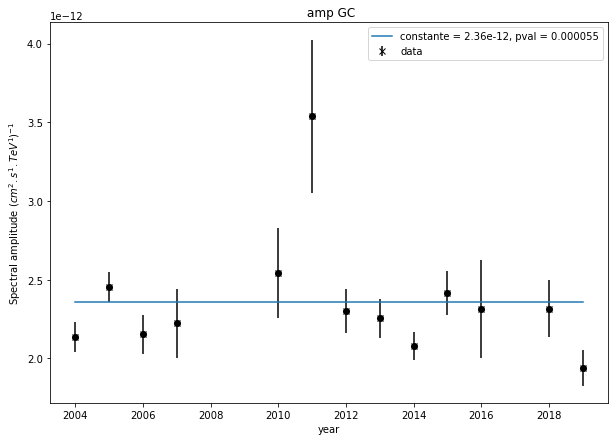

In [17]:
x = years
y = ampsGC
y_uncs = ampsGC_err

# Fit the data using a box model.
# Bounds are not really needed but included here to demonstrate usage.
t_init = models.Const1D(1e-12)
fit_t = fitting.LevMarLSQFitter()
t = fit_t(t_init, x, y) #, weights=1.0/y_uncs)

# évaluation du chi2 réduit
A1 = y
A2 = t(2004)
err_bars = y_uncs

pv = pval(A1, A2, err_bars, len(A1)-1)


# Plot the data with the best-fit model
plt.figure(figsize=(10,7))
plt.plot(x, y, 'ko')
plt.errorbar(x, y, yerr=y_uncs, fmt='kx', label="data")
plt.plot(x, t(x), label='constante = ' + str(round(t(2004), 14))+', pval = {0:0.6f}'.format(pv) )
plt.xlabel('year')
plt.ylabel(r'Spectral amplitude $(cm^2.s^1.TeV^1)^{-1}$')
plt.legend(loc=1)
plt.title(" amp GC")
plt.savefig(pathpar/"ampGC.pdf")

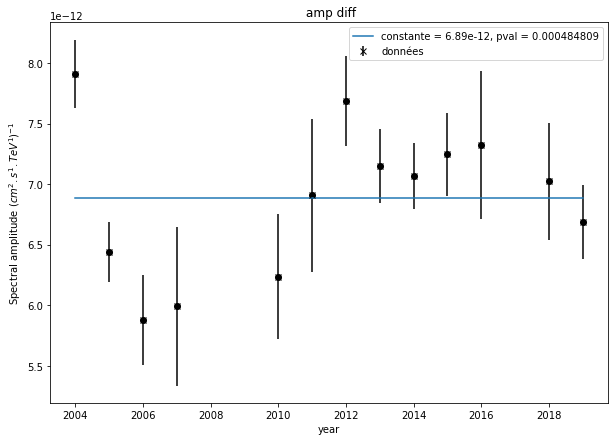

In [18]:
x = years
y = ampsdiff
y_uncs = ampsdiff_err

# Fit the data using a box model.
# Bounds are not really needed but included here to demonstrate usage.
t_init = models.Const1D(1)
fit_t = fitting.LevMarLSQFitter()
t = fit_t(t_init, x, y) #, weights=1.0/y_uncs)

# évaluation du chi2 réduit
A1 = y
A2 = t(2004)
err_bars = y_uncs

pv = pval(A1, A2, err_bars, len(A1)-1)


# Plot the data with the best-fit model
plt.figure(figsize=(10,7))
plt.plot(x, y, 'ko')
plt.errorbar(x, y, yerr=y_uncs, fmt='kx', label="données")
plt.plot(x, t(x), label='constante = ' + str(round(t(2004), 14))+ ', pval = {0:0.9f}'.format(pv) )
plt.xlabel('year')
plt.ylabel(r'Spectral amplitude $(cm^2.s^1.TeV^1)^{-1}$' )
plt.legend(loc=1)
plt.title(" amp diff" )
plt.savefig(pathpar/"ampdiff.pdf")

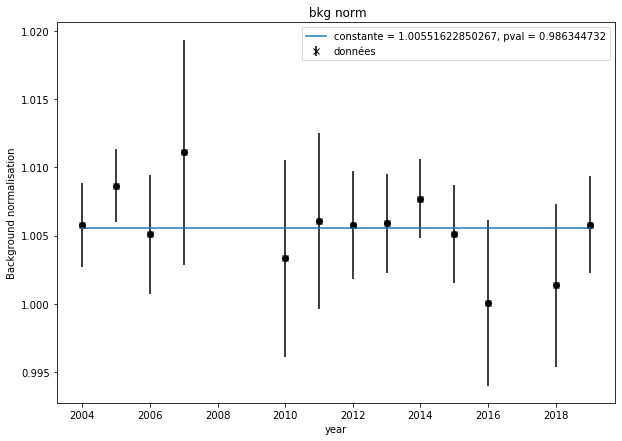

In [19]:
x = years
y = norms
y_uncs = norms_err

# Fit the data using a box model.
# Bounds are not really needed but included here to demonstrate usage.
t_init = models.Const1D(1)
fit_t = fitting.LevMarLSQFitter()
t = fit_t(t_init, x, y) #, weights=1.0/y_uncs)

# évaluation du chi2 réduit
A1 = y
A2 = t(2004)
err_bars = y_uncs

pv = pval(A1, A2, err_bars, len(A1)-1)


# Plot the data with the best-fit model
plt.figure(figsize=(10,7))
plt.plot(x, y, 'ko')
plt.errorbar(x, y, yerr=y_uncs, fmt='kx', label="données")
plt.plot(x, t(x), label='constante = ' + str(round(t(2004), 14))+ ", pval = {0:0.9f}".format(pv))
plt.xlabel('year')
plt.ylabel('Background normalisation')
plt.legend(loc=1)
plt.title(" bkg norm" )
plt.savefig(pathpar/"norm.pdf")

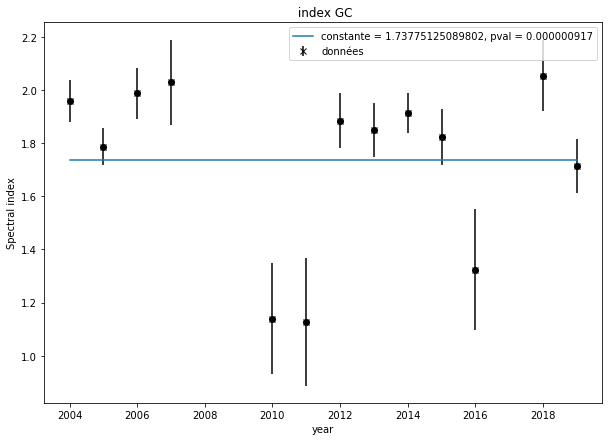

In [20]:
x = years
y = indexGC
y_uncs = indexGC_err

# Fit the data using a box model.
# Bounds are not really needed but included here to demonstrate usage.
t_init = models.Const1D(1)
fit_t = fitting.LevMarLSQFitter()
t = fit_t(t_init, x, y) #, weights=1.0/y_uncs)

# évaluation du chi2 réduit
A1 = y
A2 = t(2004)
err_bars = y_uncs

pv = pval(A1, A2, err_bars, len(A1)-1)


# Plot the data with the best-fit model
plt.figure(figsize=(10,7))
plt.plot(x, y, 'ko')
plt.errorbar(x, y, yerr=y_uncs, fmt='kx', label="données")
plt.plot(x, t(x), label='constante = ' + str(round(t(2004), 14))+ ", pval = {0:0.9f}".format(pv))
plt.xlabel('year')
plt.ylabel('Spectral index')
plt.legend(loc=1)
plt.title(" index GC")
plt.savefig(pathpar/"index_GC.pdf")

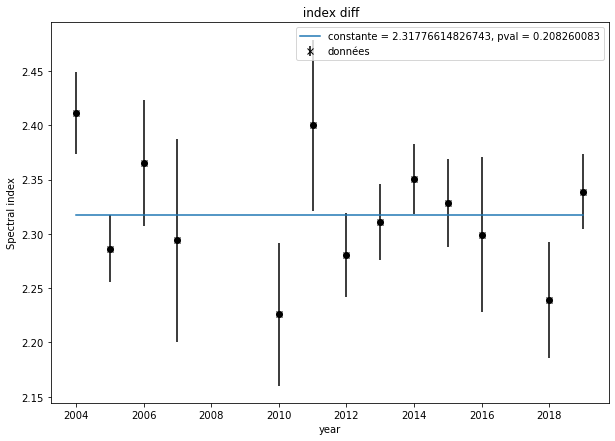

In [21]:
x = years
y = indexdiff
y_uncs = indexdiff_err

# Fit the data using a box model.
# Bounds are not really needed but included here to demonstrate usage.
t_init = models.Const1D(1)
fit_t = fitting.LevMarLSQFitter()
t = fit_t(t_init, x, y) #, weights=1.0/y_uncs)

# évaluation du chi2 réduit
A1 = y
A2 = t(2004)
err_bars = y_uncs

pv = pval(A1, A2, err_bars, len(A1)-1)


# Plot the data with the best-fit model
plt.figure(figsize=(10,7))
plt.plot(x, y, 'ko')
plt.errorbar(x, y, yerr=y_uncs, fmt='kx', label="données")
plt.plot(x, t(x), label='constante = ' + str(round(t(2004), 14))+ ", pval = {0:0.9f}".format(pv) )
plt.xlabel('year')
plt.ylabel('Spectral index')
plt.legend(loc=1)
plt.title(" index diff")
plt.savefig(pathpar/"index_diff.pdf")

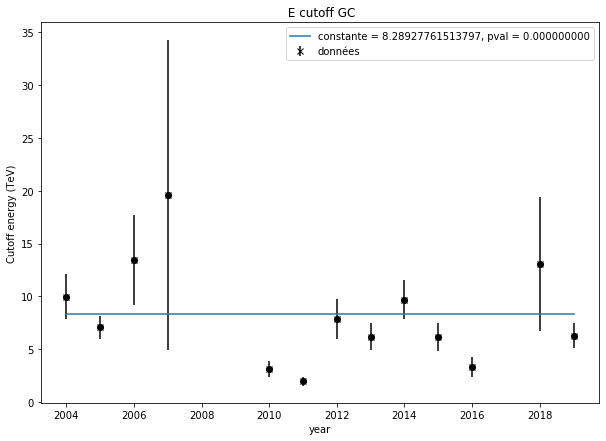

In [22]:
x = years
y = 1/np.array(lambdaGC)
y_uncs = y*(np.array(lambdaGC_err)/np.array(lambdaGC))

# Fit the data using a box model.
# Bounds are not really needed but included here to demonstrate usage.
t_init = models.Const1D(10)
fit_t = fitting.LevMarLSQFitter()
t = fit_t(t_init, x, y) #, weights=1.0/y_uncs)

# évaluation du chi2 réduit
A1 = y
A2 = t(2004)
err_bars = y_uncs

pv = pval(A1, A2, err_bars, len(A1)-1)


# Plot the data with the best-fit model
plt.figure(figsize=(10,7))
plt.plot(x, y, 'ko')
plt.errorbar(x, y, yerr=y_uncs, fmt='kx', label="données")
plt.plot(x, t(x), label='constante = ' + str(round(t(2004), 14))+ ", pval = {0:0.9f}".format(pv))
plt.xlabel('year')
plt.ylabel('Cutoff energy (TeV)')
plt.legend(loc=1)
plt.title(" E cutoff GC")
plt.savefig(pathpar/"cutoff_GC.pdf")

/home/samuel/anaconda3/envs/gammapy-0.15/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars


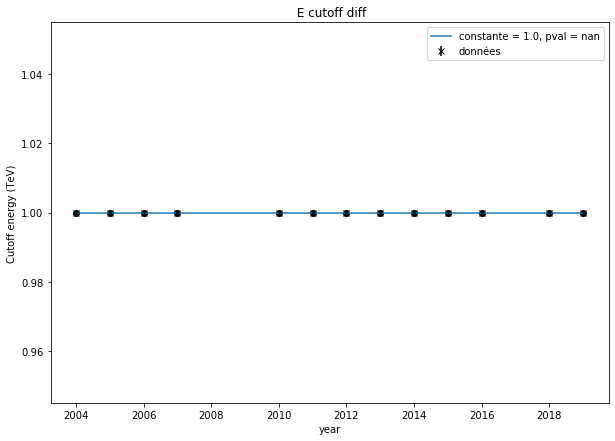

In [23]:
x = years
y = 1/np.array(lambdadiff)
y_uncs = y*(np.array(lambdadiff_err)/np.array(lambdadiff))

# Fit the data using a box model.
# Bounds are not really needed but included here to demonstrate usage.
t_init = models.Const1D(10)
fit_t = fitting.LevMarLSQFitter()
t = fit_t(t_init, x, y) #, weights=1.0/y_uncs)

# évaluation du chi2 réduit
A1 = y
A2 = t(2004)
err_bars = y_uncs

pv = pval(A1, A2, err_bars, len(A1)-1)


# Plot the data with the best-fit model
plt.figure(figsize=(10,7))
plt.plot(x, y, 'ko')
plt.errorbar(x, y, yerr=y_uncs, fmt='kx', label="données")
plt.plot(x, t(x), label='constante = ' + str(round(t(2004), 14))+ ", pval = {0:0.9f}".format(pv))
plt.xlabel('year')
plt.ylabel('Cutoff energy (TeV)')
plt.legend(loc=1)
plt.title(" E cutoff diff")
plt.savefig(pathpar/"cutoff_diff.pdf")

## Flux points

One alternative way to assess spectral variability over the years is to compute flux points for each year (but on quite large energy bins since we will lack the data to compute more than a few points).

In [24]:
from gammapy.spectrum import FluxPoints, FluxPointsDataset, FluxPointsEstimator

In [25]:
def FluxPointsFitting(dataset, e_edges):
    # this function has to be given the number of the source model in case of multiple models
    # more parameters exist to initialise the estimator
    fpe = FluxPointsEstimator(datasets=[dataset], e_edges=e_edges, source=0) 
    flux_points = fpe.run()
    return flux_points

In [26]:
e_edges = np.array([0.5,1,2,5,10]) * u.TeV

In [ ]:
flux_years = {0 : [], 1 : [], 2 : [], 3 : []}

for year in years:
    flux_points = FluxPointsFitting(mapdataset_dict[year], e_edges)
    for k in range(len(e_edges) - 1):
        flux_years[k].append(flux_points.table[k])

In [ ]:
x = years

for k in range(len(e_edges) - 1) :
    y = []
    y_uncs = []
   
    for l,year in zip(range(len(years)),years):
        y.append(flux_years[k][l]['dnde'])
        y_uncs.append(flux_years[k][l]['dnde_err'])

    
    t_init = models.Const1D(1e-12)
    fit_t = fitting.LevMarLSQFitter()
    t = fit_t(t_init, x, y) #, weights=1.0/y_uncs)

    A1 = y
    A2 = t(2004)
    err_bars = y_uncs
    
    pv = pval(A1, A2, err_bars, len(A1)-1)
    
    plt.figure(figsize=(10,7))
    plt.plot(x, y, 'ko')
    plt.errorbar(x, y, yerr=y_uncs, fmt='kx', label="data")
    
    plt.plot(x, t(x), label='constant = ' + str(round(t(2004), 14))+ ", pval = {0:0.5f}".format(pv) )
    
    plt.xlabel('year')
    plt.ylabel('Flux (1/cm²s¹)')
    
    plt.legend(loc=1)
    
    plt.title("Flux points of HESS J1745-290 ("+str(e_edges[k]) +" - "+ str(e_edges[k+1])+")")
    name = "GC_FP_bin"+str(k)+"_fr.pdf"
    plt.savefig(pathpar/name)